# <span style="color:blue"> Different stages of Alzheimer by CNN and Tranfer Learining </span>
Please refer to the corresponding [kaggle link](https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images?select=Alzheimer_s+Dataset) for detals of the data set.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.applications.mobilenet_v2 as mobilenet
tfl = tf.keras.layers

## Load train and test data sets from images
We use [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) from tensorflow.keras.preprocessing to do this task.

In [11]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
print("load train data set:")
train_ds = image_dataset_from_directory("Alzheimer_Dataset/train",
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE,
                                        seed=0)
print("load test data set:")
test_ds = image_dataset_from_directory("Alzheimer_Dataset/test",
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE,
                                        seed=0)

load train data set:
Found 5121 files belonging to 4 classes.
load test data set:
Found 1279 files belonging to 4 classes.


class names are ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


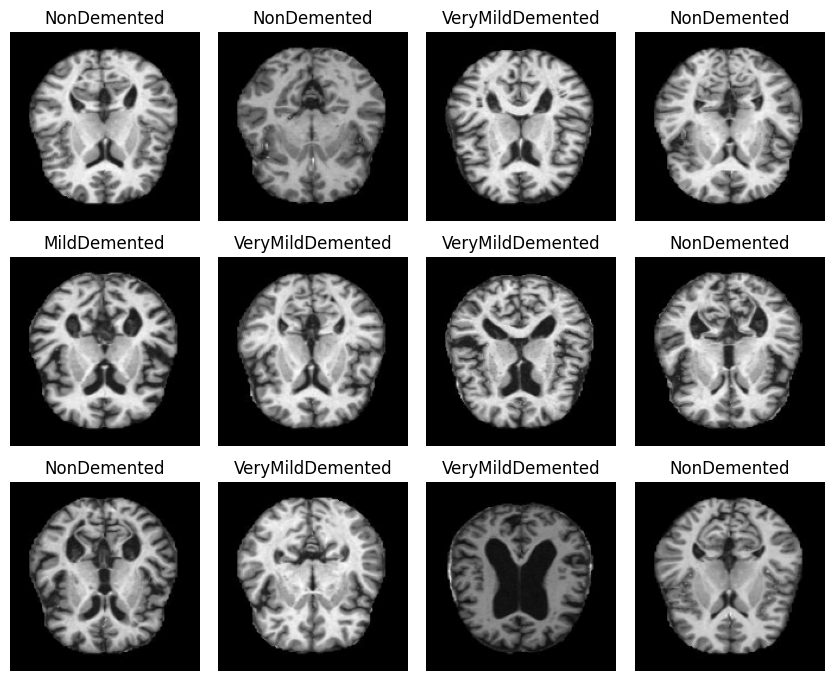

In [16]:
class_names = train_ds.class_names
print(f"class names are {class_names}")
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10.5, 8.5))
fig.subplots_adjust(wspace=0.1, hspace=0.1)

images, labels = next(iter(train_ds))
for i in range(12):
    a = ax.flat[i]
    a.imshow(images[i].numpy().astype("uint8"))
    a.set_title(class_names[labels[i]])
    a.set_axis_off()

plt.show()

In [17]:
# prefetch the training data
# see the corresponding documentation link at https://www.tensorflow.org/guide/data_performance for detail.
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Data distribution

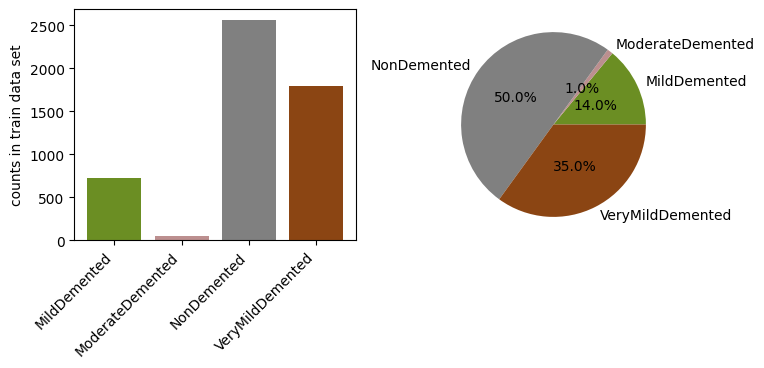

In [138]:
index = np.array([],dtype="int32");
for element in train_ds.as_numpy_iterator():
    index = np.append(index,element[1])
    
unique, counts = np.unique(index, return_counts=True)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
colors=['olivedrab', 'rosybrown', 'gray', 'saddlebrown']
ax[0].bar(unique,counts,color=colors)
ax[0].set_ylabel(f"counts in train data set")
ax[0].set_xticks(np.arange(len(unique)))
ax[0].set_xticklabels([class_names[i] for i in unique], rotation=45, ha='right')

ax[1].pie(counts/counts.sum(), labels=[class_names[i] for i in unique],
          autopct='%1.1f%%',pctdistance=0.5, labeldistance=1.1, colors=colors)


plt.show()

## Data augmentation

In [21]:
data_augmenter = tf.keras.Sequential([
    tfl.RandomFlip(mode="horizontal_and_vertical"),
    tfl.RandomRotation(factor=0.25)
])

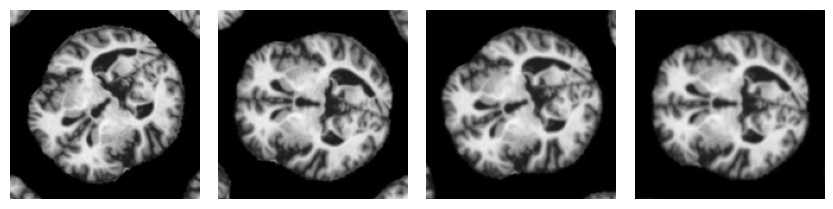

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10.5, 2.5))
fig.subplots_adjust(wspace=0.1)

images, _ = next(iter(train_ds))
image = tf.expand_dims(images[0], 0)
for i in range(4):
    image = data_augmenter(image)
    a = ax.flat[i]
    a.imshow(image[0].numpy().astype("uint8"))
    a.set_axis_off()

plt.show()